In [320]:
#! pip install unidecode
#! pip install contractions

import numpy as np
import pandas as pd
import sys
import spacy
import re, string, unicodedata
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.externals import joblib

In [195]:
data = pd.read_csv("/Users/laurenyoshizuka/Library/Mobile Documents/com~apple~CloudDocs/1_CentraleSupelec/Y2/Ensemble Learning/Project/cyberbullying_tweets.csv")

In [196]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [197]:
# dependent variable distributions
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

labels a fairly balanced

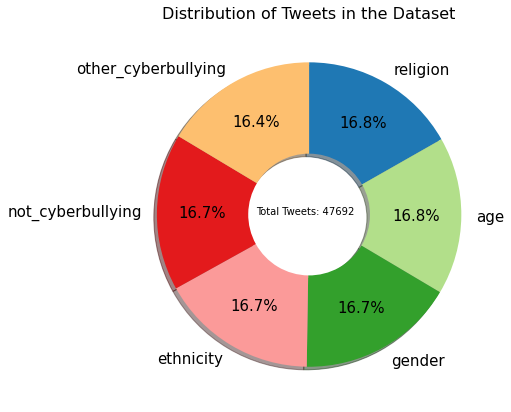

In [304]:
plt.figure(figsize = (7,7))
sorted_counts = data['cyberbullying_type'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[1:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(data.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

In [198]:
# text preprocessing ... removing punctuation and non text characters: 
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
data['clean_tweet1']= data['tweet_text'].apply(lambda x:remove_punctuation(x))
data.head()

,tweet_text,cyberbullying_type,clean_tweet1
0,"In other words #katandandre, your food was cra...",not_cyberbullying,In other words katandandre your food was crapi...
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why is aussietv so white MKR theblock ImACeleb...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,XochitlSuckkks a classy whore Or more red velv...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,JasonGio meh P thanks for the heads up but no...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,RudhoeEnglish This is an ISIS account pretendi...


In [199]:
# convert to lowercase
data['clean_tweet2']= data['clean_tweet1'].apply(lambda x: x.lower())
data.head()

,tweet_text,cyberbullying_type,clean_tweet1,clean_tweet2
0,"In other words #katandandre, your food was cra...",not_cyberbullying,In other words katandandre your food was crapi...,in other words katandandre your food was crapi...
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why is aussietv so white MKR theblock ImACeleb...,why is aussietv so white mkr theblock imaceleb...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,XochitlSuckkks a classy whore Or more red velv...,xochitlsuckkks a classy whore or more red velv...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,JasonGio meh P thanks for the heads up but no...,jasongio meh p thanks for the heads up but no...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,RudhoeEnglish This is an ISIS account pretendi...,rudhoeenglish this is an isis account pretendi...


In [259]:
# tokenization

def tokenization(text):
    #tokens = re.split('W+',text)
    tokens = word_tokenize(text)
    result = [i for i in tokens]   
    return tokens
#applying function to the column
data['tokenized_tweet']= data['clean_tweet2'].apply(lambda x: tokenization(x))

In [ ]:
data.head()

In [202]:
# stopword removal
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

data['no_stopwords']= data['tokenized_tweet'].apply(lambda x:remove_stopwords(x))


In [203]:
data.head()

,tweet_text,cyberbullying_type,clean_tweet1,clean_tweet2,tokenized_tweet,no_stopwords
0,"In other words #katandandre, your food was cra...",not_cyberbullying,In other words katandandre your food was crapi...,in other words katandandre your food was crapi...,"[in, other, words, katandandre, your, food, wa...","[words, katandandre, food, crapilicious, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why is aussietv so white MKR theblock ImACeleb...,why is aussietv so white mkr theblock imaceleb...,"[why, is, aussietv, so, white, mkr, theblock, ...","[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,XochitlSuckkks a classy whore Or more red velv...,xochitlsuckkks a classy whore or more red velv...,"[xochitlsuckkks, a, classy, whore, or, more, r...","[xochitlsuckkks, classy, whore, red, velvet, c..."
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,JasonGio meh P thanks for the heads up but no...,jasongio meh p thanks for the heads up but no...,"[jasongio, meh, p, thanks, for, the, heads, up...","[jasongio, meh, p, thanks, heads, concerned, a..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,RudhoeEnglish This is an ISIS account pretendi...,rudhoeenglish this is an isis account pretendi...,"[rudhoeenglish, this, is, an, isis, account, p...","[rudhoeenglish, isis, account, pretending, kur..."


In [204]:
# stemming
stemmer = PorterStemmer()

def stemming(text):
    stem_text = [stemmer.stem(word) for word in text]
    return stem_text

data['tweet_stemmed']=data['no_stopwords'].apply(lambda x: stemming(x))

In [205]:
data[['no_stopwords','tweet_stemmed']].head(50)

,no_stopwords,tweet_stemmed
0,"[words, katandandre, food, crapilicious, mkr]","[word, katandandr, food, crapilici, mkr]"
1,"[aussietv, white, mkr, theblock, imacelebritya...","[aussietv, white, mkr, theblock, imacelebritya..."
2,"[xochitlsuckkks, classy, whore, red, velvet, c...","[xochitlsuckkk, classi, whore, red, velvet, cu..."
3,"[jasongio, meh, p, thanks, heads, concerned, a...","[jasongio, meh, p, thank, head, concern, anoth..."
4,"[rudhoeenglish, isis, account, pretending, kur...","[rudhoeenglish, isi, account, pretend, kurdish..."
5,"[raja5aab, quickieleaks, yes, test, god, good,...","[raja5aab, quickieleak, ye, test, god, good, b..."
6,"[itu, sekolah, ya, bukan, tempat, bully, ga, j...","[itu, sekolah, ya, bukan, tempat, bulli, ga, j..."
7,"[karma, hope, bites, kat, butt, nasty, mkr]","[karma, hope, bite, kat, butt, nasti, mkr]"
8,"[stockputout, everything, mostly, priest]","[stockputout, everyth, mostli, priest]"
9,"[rebecca, black, drops, school, due, bullying]","[rebecca, black, drop, school, due, bulli]"


In [206]:
# Lemmatization to ensure word meaning not lost during stemming
wnl = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wnl.lemmatize(word) for word in text]
    return lemm_text
data['tweet_lemmatized']=data['no_stopwords'].apply(lambda x:lemmatizer(x))

In [207]:
data[['no_stopwords','tweet_stemmed','tweet_lemmatized']].head(20)

,no_stopwords,tweet_stemmed,tweet_lemmatized
0,"[words, katandandre, food, crapilicious, mkr]","[word, katandandr, food, crapilici, mkr]","[word, katandandre, food, crapilicious, mkr]"
1,"[aussietv, white, mkr, theblock, imacelebritya...","[aussietv, white, mkr, theblock, imacelebritya...","[aussietv, white, mkr, theblock, imacelebritya..."
2,"[xochitlsuckkks, classy, whore, red, velvet, c...","[xochitlsuckkk, classi, whore, red, velvet, cu...","[xochitlsuckkks, classy, whore, red, velvet, c..."
3,"[jasongio, meh, p, thanks, heads, concerned, a...","[jasongio, meh, p, thank, head, concern, anoth...","[jasongio, meh, p, thanks, head, concerned, an..."
4,"[rudhoeenglish, isis, account, pretending, kur...","[rudhoeenglish, isi, account, pretend, kurdish...","[rudhoeenglish, isi, account, pretending, kurd..."
5,"[raja5aab, quickieleaks, yes, test, god, good,...","[raja5aab, quickieleak, ye, test, god, good, b...","[raja5aab, quickieleaks, yes, test, god, good,..."
6,"[itu, sekolah, ya, bukan, tempat, bully, ga, j...","[itu, sekolah, ya, bukan, tempat, bulli, ga, j...","[itu, sekolah, ya, bukan, tempat, bully, ga, j..."
7,"[karma, hope, bites, kat, butt, nasty, mkr]","[karma, hope, bite, kat, butt, nasti, mkr]","[karma, hope, bite, kat, butt, nasty, mkr]"
8,"[stockputout, everything, mostly, priest]","[stockputout, everyth, mostli, priest]","[stockputout, everything, mostly, priest]"
9,"[rebecca, black, drops, school, due, bullying]","[rebecca, black, drop, school, due, bulli]","[rebecca, black, drop, school, due, bullying]"


In [262]:
# convert list to string for TF IDF

data['tweet_str'] = [','.join(map(str, l)) for l in data['tweet_lemmatized']]
data.head()

,tweet_text,cyberbullying_type,clean_tweet1,clean_tweet2,tokenized_tweet,no_stopwords,tweet_stemmed,tweet_lemmatized,tweet_str
0,"In other words #katandandre, your food was cra...",not_cyberbullying,In other words katandandre your food was crapi...,in other words katandandre your food was crapi...,"[in, other, words, katandandre, your, food, wa...","[words, katandandre, food, crapilicious, mkr]","[word, katandandr, food, crapilici, mkr]","[word, katandandre, food, crapilicious, mkr]","word,katandandre,food,crapilicious,mkr"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why is aussietv so white MKR theblock ImACeleb...,why is aussietv so white mkr theblock imaceleb...,"[why, is, aussietv, so, white, mkr, theblock, ...","[aussietv, white, mkr, theblock, imacelebritya...","[aussietv, white, mkr, theblock, imacelebritya...","[aussietv, white, mkr, theblock, imacelebritya...","aussietv,white,mkr,theblock,imacelebrityau,tod..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,XochitlSuckkks a classy whore Or more red velv...,xochitlsuckkks a classy whore or more red velv...,"[xochitlsuckkks, a, classy, whore, or, more, r...","[xochitlsuckkks, classy, whore, red, velvet, c...","[xochitlsuckkk, classi, whore, red, velvet, cu...","[xochitlsuckkks, classy, whore, red, velvet, c...","xochitlsuckkks,classy,whore,red,velvet,cupcake"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,JasonGio meh P thanks for the heads up but no...,jasongio meh p thanks for the heads up but no...,"[jasongio, meh, p, thanks, for, the, heads, up...","[jasongio, meh, p, thanks, heads, concerned, a...","[jasongio, meh, p, thank, head, concern, anoth...","[jasongio, meh, p, thanks, head, concerned, an...","jasongio,meh,p,thanks,head,concerned,another,a..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,RudhoeEnglish This is an ISIS account pretendi...,rudhoeenglish this is an isis account pretendi...,"[rudhoeenglish, this, is, an, isis, account, p...","[rudhoeenglish, isis, account, pretending, kur...","[rudhoeenglish, isi, account, pretend, kurdish...","[rudhoeenglish, isi, account, pretending, kurd...","rudhoeenglish,isi,account,pretending,kurdish,a..."


In [263]:
# fully cleaned
data.shape

(47692, 9)

# Feature Selection & Train Test Split

In [264]:
from sklearn.model_selection import train_test_split

X = data.tweet_str
y = data.cyberbullying_type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


In [265]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33384,) (14308,) (33384,) (14308,)


In [266]:
X_train, X_test, y_train, y_test

(12276    marleygotboobs,gay,r,sissis,st8,men,r,run,pris...
 17518    newsflashthat,evilanglistis,christian,deplorab...
 4127     ncweaver,ive,ran,difficulty,getting,respond,we...
 19027    satire,free,speech,pretending,solve,nothing,pr...
 23449    know,historically,burned,book,nazi,radical,chr...
                                ...                        
 11284    female,like,roseanne,barr,2,hideous,bitch,call...
 44732    it,question,dumb,telly,tubby,ya,clit,fat,pussy...
 38158    one,kid,turned,leftist,like,bully,friend,kid,i...
 860      rt,ravenhuwolf,university,texasarlington,musli...
 15795    doctrinedark798,able,save,hereright,click,hold...
 Name: tweet_str, Length: 33384, dtype: object,
 40362    goreejuhssguns,hahaha,aint,even,worth,tweet,du...
 15019    rt,hsaymssik,suck,smile,wiped,face,huh,kat,gla...
 46321    reminder,absolutely,disgusting,see,people,woul...
 23927    rt,buzzfeeduk,accidentally,open,front,camera,h...
 1640                               loving,look,frit

# TF IDF matrix

In [267]:
#tf idf vectorizer 
tf_idf = TfidfVectorizer()

#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(X_train)

#applying tf idf to training data
X_train_tf = tf_idf.transform(X_train)

In [268]:
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 33384, n_features: 49271


In [270]:
#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(X_test)

In [271]:
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 14308, n_features: 49271


In [ ]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

# Naive Bayes

In [275]:
#naive bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)

MultinomialNB()

In [276]:
#predicted y
y_pred = naive_bayes_classifier.predict(X_test_tf)

In [280]:
# remind of target names
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [281]:
print(metrics.classification_report(y_test, y_pred, target_names=['religion','age','gender','ethnicity','not_cyberbullying','other_cyberbullying']))

                     precision    recall  f1-score   support

           religion       0.68      0.99      0.80      2349
                age       0.84      0.91      0.87      2418
             gender       0.80      0.85      0.82      2343
          ethnicity       0.71      0.34      0.46      2466
  not_cyberbullying       0.66      0.43      0.52      2391
other_cyberbullying       0.76      0.98      0.86      2341

           accuracy                           0.75     14308
          macro avg       0.74      0.75      0.72     14308
       weighted avg       0.74      0.75      0.72     14308



In [283]:
# check confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

Confusion matrix:
[[2321   10    7    1    0   10]
 [ 113 2193   17    1    8   86]
 [  67   70 1998   89   57   62]
 [ 463  143  229  830  474  327]
 [ 448  193  250  243 1032  225]
 [  24    7    9   13    2 2286]]


# implement a pipeline...not working yet

In [321]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

In [334]:
# make a list of models
models = [MultinomialNB(), DecisionTreeClassifier(), LinearSVC(), AdaBoostClassifier(), 
          RandomForestClassifier(), BaggingClassifier(),
         LogisticRegression(), SGDClassifier(), KNeighborsClassifier()]

In [335]:
re = pipeline(models, X_train_tf, y_train, X_test_tf, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training MultinomialNB


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)